# Model Development

load dataset

In [1]:
import pandas as pd

concrete =pd.read_csv('../data/clean_data1.csv')
concrete.head() 

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength,water_cement_ratio
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,0.300000
1,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847,0.857143
2,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770,0.600000
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291,0.857143
4,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790,0.480000


### `K-fold Cross validations and Randomized Search for hyperparameter tunning`
Data was split into 10 equal parts with 10-folds CV
 * 9 parts are used for training
 * 1 part is used for validation

X = features

y = label (Compressive strength)

In [2]:
concrete.columns = concrete.columns.str.strip()
print(concrete.columns)

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength',
       'water_cement_ratio'],
      dtype='object')


In [3]:
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error as MAE
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

In [5]:
X = concrete.drop("compressive_strength", axis=1).values
y = concrete["compressive_strength"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [6]:
def randomized_search_all(X_train, y_train, X_test, y_test, n_iter=20, cv_splits=10):
    # models and parameter grids
    models_params ={
        "AdaBoost": (
            AdaBoostRegressor(random_state=100),
            {
                "n_estimators": [50, 100, 200, 300],
                "learning_rate": np.linspace(0.01, 1.0, 10)
            }
        ),
        "Random Forest" :(
            RandomForestRegressor(random_state=100),
            {
                "n_estimators": [100, 200, 300],
                "max_depth" : [5, 10, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        ),
        "XGBoost": (
            XGBRegressor(random_state=100, eval_metric='rmse'),
            {
                "n_estimators": [100, 200, 500],
                "learning_rate": [0.01, 0.005, 0.1, 0.3],
                "max_depth": [3, 5, 7, 9],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            }
        ),
        "LightGMB": (
            LGBMRegressor(random_state=100, verbose=1, force_col_wise=True),
            {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1],
                "num_leaves": [20, 30, 40]
            }
        ),
        "CatBost": (
            CatBoostRegressor(random_state=100, verbose=0, allow_writing_files=False),
            {
                "iterations": [200, 500, 800],
                "learning_rate": [0.01, 0.05, 0.1],
                "depth": [4, 6, 8, 10]
            }
        )
    }
    results ={}
    kfold = KFold(n_splits=cv_splits, shuffle = True, random_state=100)

    for name, (model, param_dist) in models_params.items():
        print(f"\nRunning RandomizedSearchCV for {name}...")

        random_search = RandomizedSearchCV(
            estimator = model,
            param_distributions = param_dist,
            n_iter = n_iter,
            scoring = 'r2',
            cv=kfold,
            verbose = 1,
            n_jobs = -1,
            random_state=100
        )
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)

        results[name] = {
            "best_params": random_search.best_params_,
            "cv_r2": random_search.best_score_,
            "test_r2": r2_score(y_test, y_pred),
            "test_rmse": MSE(y_test, y_pred)**(1/2),
            "test_mae": MAE(y_test, y_pred),
            "best_model": best_model
        }
        print(f"{name} done! Best R2 CV: {random_search.best_score_:.4f}, Test R2: {results[name]['test_r2']:.4f}")

    return results

In [7]:
results = randomized_search_all(X_train, y_train, X_test, y_test)


Running RandomizedSearchCV for AdaBoost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
AdaBoost done! Best R2 CV: 0.7845, Test R2: 0.8103

Running RandomizedSearchCV for Random Forest...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Random Forest done! Best R2 CV: 0.8870, Test R2: 0.9368

Running RandomizedSearchCV for XGBoost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
XGBoost done! Best R2 CV: 0.9138, Test R2: 0.9588

Running RandomizedSearchCV for LightGMB...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 728, number of used features: 9
[LightGBM] [Info] Start training from score 33.945960
LightGMB done! Best R2 CV: 0.9172, Test R2: 0.9523

Running RandomizedSearchCV for CatBost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


CatBost done! Best R2 CV: 0.9201, Test R2: 0.9564


In [8]:
import pandas as pd

pd.DataFrame.from_dict(results, orient='index')

,best_params,cv_r2,test_r2,test_rmse,test_mae,best_model
AdaBoost,"{'n_estimators': 100, 'learning_rate': 0.56}",0.784544,0.810287,7.005673,5.564674,"(DecisionTreeRegressor(max_depth=3, random_sta..."
Random Forest,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.886984,0.936817,4.042959,3.008882,"(DecisionTreeRegressor(max_depth=10, max_featu..."
XGBoost,"{'subsample': 0.6, 'n_estimators': 200, 'max_d...",0.913806,0.958832,3.263496,2.424456,"XGBRegressor(base_score=None, booster=None, ca..."
LightGMB,"{'num_leaves': 20, 'n_estimators': 200, 'learn...",0.917249,0.952316,3.512282,2.535519,"LGBMRegressor(force_col_wise=True, n_estimator..."
CatBost,"{'learning_rate': 0.05, 'iterations': 500, 'de...",0.920144,0.956396,3.358647,2.489573,<catboost.core.CatBoostRegressor object at 0x0...


In [10]:

# We have best params :
best_params_xgb = {"n_estimators": 200,
                "learning_rate": 0.1,
                "max_depth": 5,
                "subsample": 0.6,
                "colsample_bytree": 0.6}
           
best_params_lgbm = {
                "n_estimators": 200,
                "learning_rate": 0.1,
                "num_leaves": 20
            }
best_params_cat = {
                "iterations": 500,
                "learning_rate": 0.05,
                "depth": 6
                }
best_params_rf =  {
                "n_estimators": 300,
                "max_depth" : 10,
                "min_samples_split": 2,
                "min_samples_leaf": 1
            }


# Define models using best hyperparameters
xgb = XGBRegressor(**best_params_xgb, random_state=100)
lgbm = LGBMRegressor(**best_params_lgbm, random_state=100)
cat = CatBoostRegressor(**best_params_cat, verbose=0, random_state=100)
rf = RandomForestRegressor(**best_params_rf, random_state=100)


# Voting Regressor
voting_reg = VotingRegressor(
    estimators=[('x-gradientboost', xgb), ('light-gradientboost', lgbm), ('catboost', cat)]
)
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)
print("Voting Regressor R2:", r2_score(y_test, y_pred_voting))
print("Voting Regressor RMSE:", MSE(y_test, y_pred_voting)**(1/2))
print("Voting Regressor MAE:", MAE(y_test, y_pred_voting))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 728, number of used features: 9
[LightGBM] [Info] Start training from score 33.945960
Voting Regressor R2: 0.9608850856062617
Voting Regressor RMSE: 3.181061547539739
Voting Regressor MAE: 2.3208160652744043


c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [11]:
# Stacking Regressor

stacking_reg = StackingRegressor(
    estimators=[('Random_Forest', rf), ('x-gradientboost', xgb), ('catboost', cat)],
    final_estimator=RidgeCV()
)
stacking_reg.fit(X_train, y_train)
y_pred_stack = stacking_reg.predict(X_test)
print("Stacking Regressor R2:", r2_score(y_test, y_pred_stack))
print("Stacking Regressor RMSE:", MSE(y_test, y_pred_stack)**(1/2))
print("Stacking Regressor MAE:", MAE(y_test, y_pred_stack))

Stacking Regressor R2: 0.9621920367379787
Stacking Regressor RMSE: 3.1274654532114985
Stacking Regressor MAE: 2.2723170765162415


c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


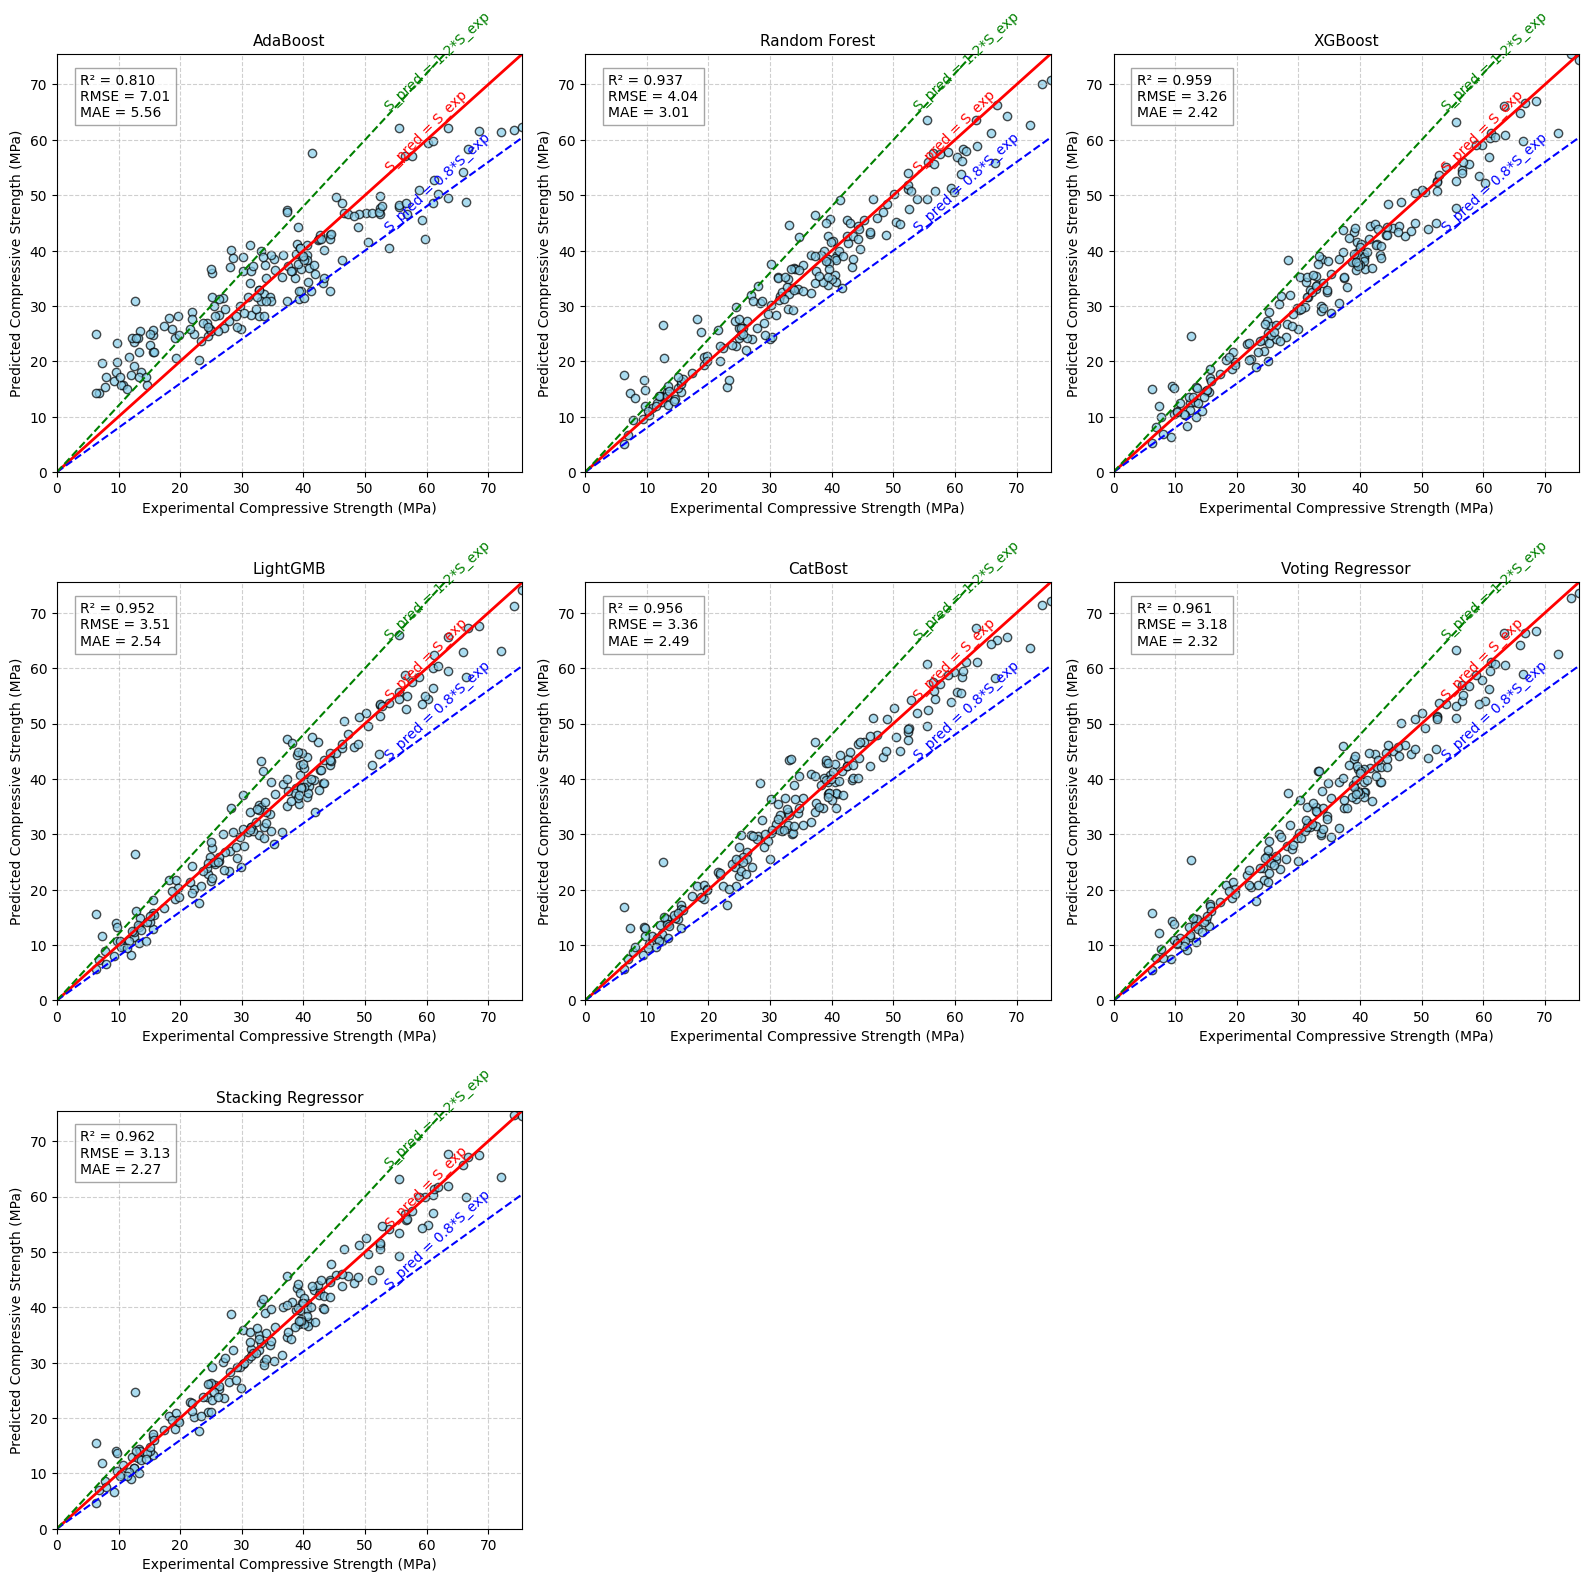

In [15]:

# Collect predictions and metrics
model_predictions = {}
model_metrics = {}

for model_name, model_info in results.items():
    best_model = model_info["best_model"]
    y_pred = best_model.predict(X_test)
    model_predictions[model_name] = y_pred

    model_metrics[model_name] = {
        "R²": r2_score(y_test, y_pred),
        "RMSE": MSE(y_test, y_pred)**(1/2),
        "MAE": MAE(y_test, y_pred)
    }

# Add ensemble models
model_predictions["Voting Regressor"] = y_pred_voting
model_predictions["Stacking Regressor"] = y_pred_stack

# Compute metrics for ensembles
for name, y_pred in {"Voting Regressor": y_pred_voting, "Stacking Regressor": y_pred_stack}.items():
    model_metrics[name] = {
        "R²": r2_score(y_test, y_pred),
        "RMSE": MSE(y_test, y_pred)**(1/2),
        "MAE": MAE(y_test, y_pred)
    }

# --- Plot setup ---
n_models = len(model_predictions)
cols = 3
rows = int(np.ceil(n_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
axes = axes.flatten()

max_val = max(y_test.max(), max([pred.max() for pred in model_predictions.values()]))

# --- Plot each model ---
for ax, (name, y_pred) in zip(axes, model_predictions.items()):
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolor='k', color='skyblue')

    # Solid line: perfect prediction
    ax.plot([0, max_val], [0, max_val], color='red', linestyle='-', linewidth=2)
    ax.text(max_val*0.7, max_val*0.72, 'S_pred = S_exp', color='red', fontsize=10, rotation=45)

    # Dashed lines: ±20% deviation
    ax.plot([0, max_val], [0, 0.8*max_val], color='blue', linestyle='--')
    ax.text(max_val*0.7, 0.8*max_val*0.72, 'S_pred = 0.8*S_exp', color='blue', fontsize=10, rotation=43)

    ax.plot([0, max_val], [0, 1.2*max_val], color='green', linestyle='--')
    ax.text(max_val*0.7, 1.2*max_val*0.72, 'S_pred = 1.2*S_exp', color='green', fontsize=10, rotation=43)

    # Add metrics box (on left)
    metrics = model_metrics[name]
    textstr = f"R² = {metrics['R²']:.3f}\nRMSE = {metrics['RMSE']:.2f}\nMAE = {metrics['MAE']:.2f}"
    ax.text(0.05*max_val, 0.85*max_val, textstr,
            fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    # Titles and labels
    ax.set_title(name, fontsize=11)
    ax.set_xlabel("Experimental Compressive Strength (MPa)")
    ax.set_ylabel("Predicted Compressive Strength (MPa)")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

# Remove empty subplots
for i in range(len(model_predictions), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## SHAP ANALYSIS

Explaining Random_Forest...
Explaining x-gradientboost...
Explaining catboost...


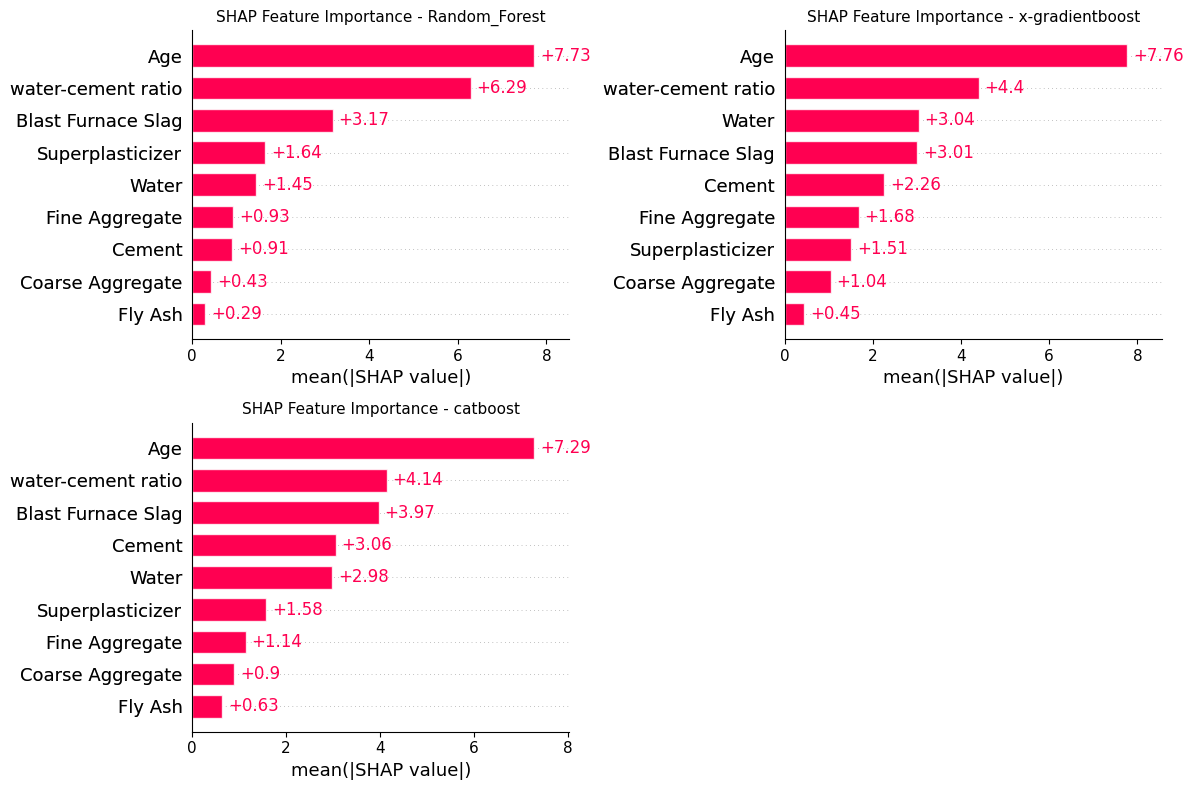

In [12]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split


feature_names = [
    "Cement", "Blast Furnace Slag", "Fly Ash", 
    "Water", "Superplasticizer", "Coarse Aggregate", 
    "Fine Aggregate", "Age", "water-cement ratio"
]

# Example: if X is a NumPy array
import pandas as pd
X = pd.DataFrame(X, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


base_models = stacking_reg.named_estimators_

n_models = len(base_models)
cols = 2
rows = (n_models + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, (name, model) in enumerate(base_models.items()):
    print(f"Explaining {name}...")
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap.plots.bar(shap_values, show=False, ax=axes[i])
    axes[i].set_title(f"SHAP Feature Importance - {name}", fontsize=11)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

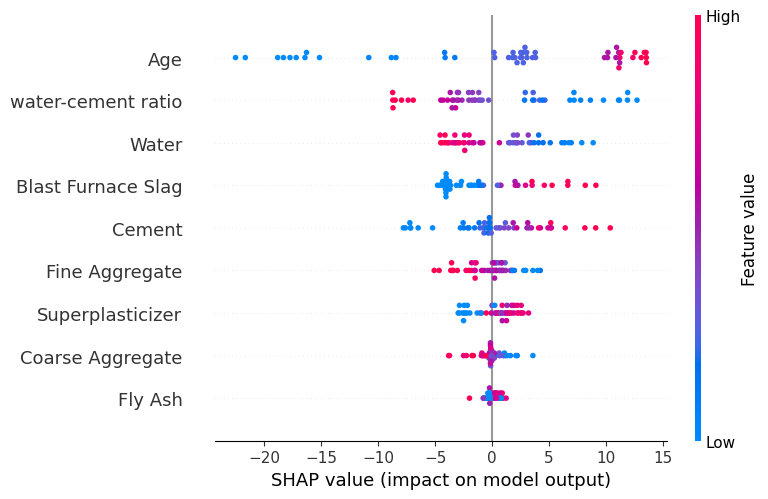

In [20]:
import shap
import numpy as np

# Sample fewer rows for speed (SHAP can be heavy)
X_sample = X_train.sample(200, random_state=42)

explainer = shap.KernelExplainer(stacking_reg.predict, X_sample)
shap_values = explainer.shap_values(X_test.sample(50, random_state=42))

# Plot global importance
shap.summary_plot(shap_values, X_test.sample(50, random_state=42))


['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'water-cement ratio']


c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\Danhaya\miniconda3\Lib\site-packages\skle

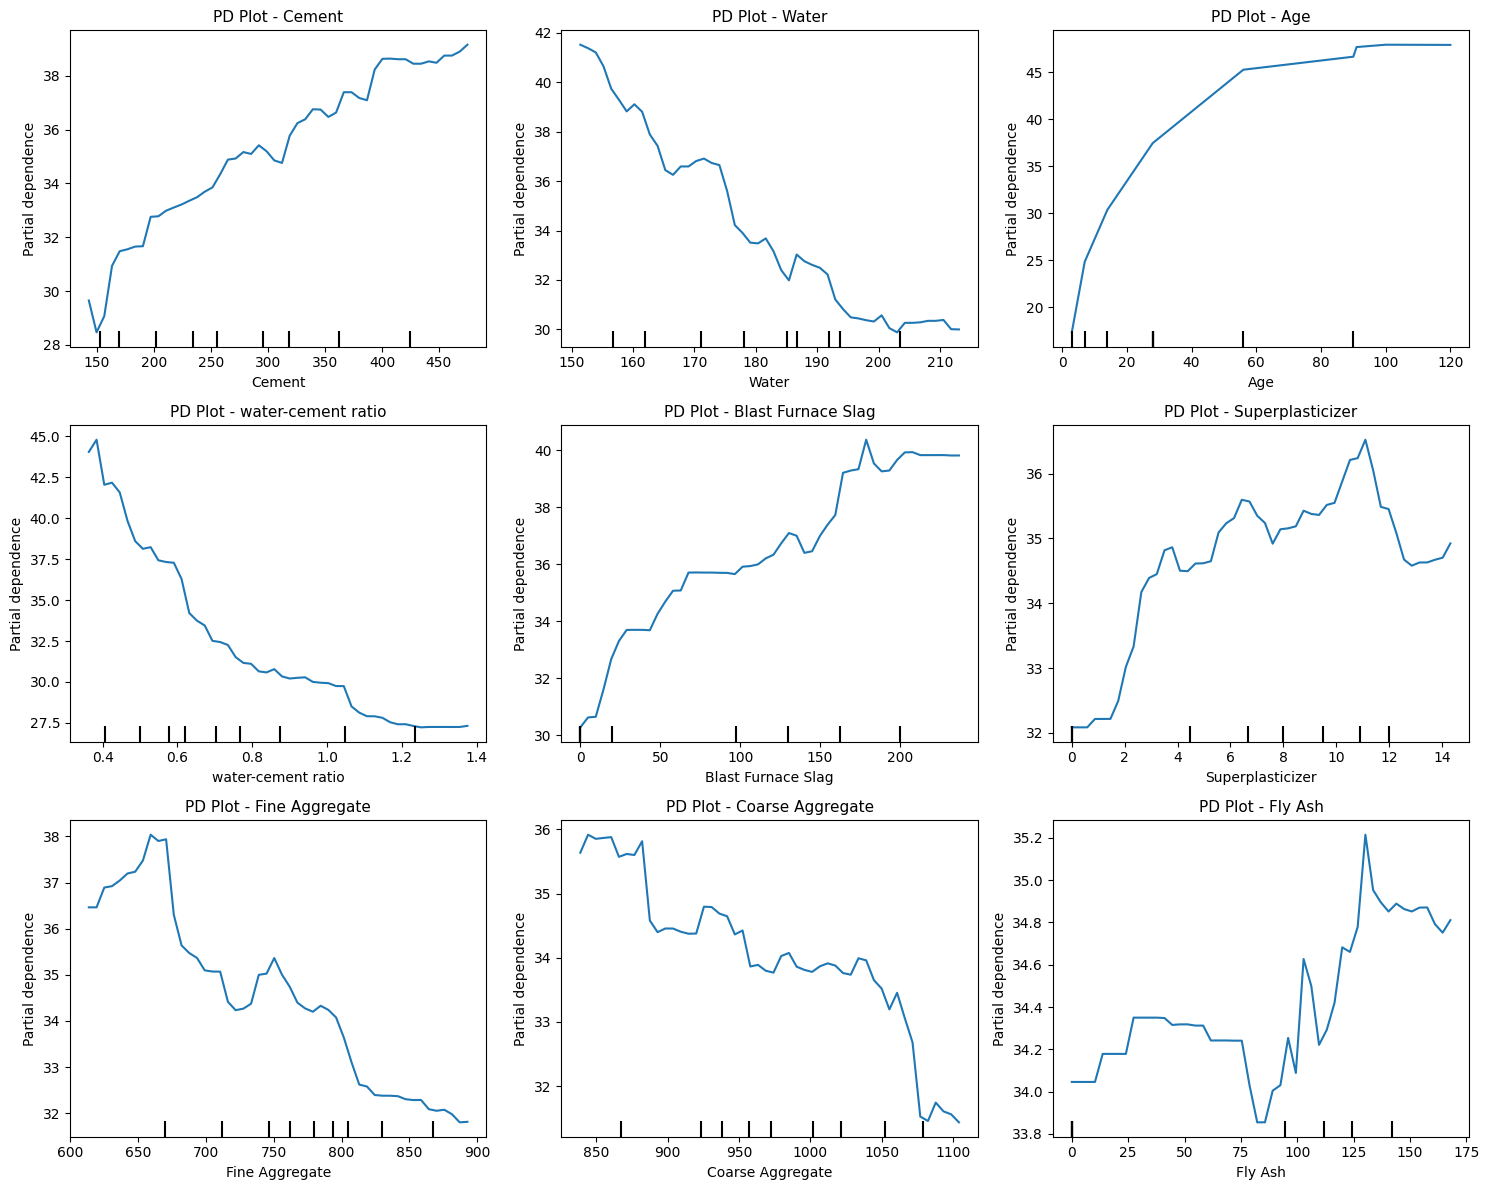

In [18]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Check column names
print(X_train.columns.tolist())

top_features = ["Cement", "Water", "Age", "water-cement ratio", 
                "Blast Furnace Slag", "Superplasticizer", 
                "Fine Aggregate", "Coarse Aggregate", "Fly Ash"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    if feature in X_train.columns:
        display = PartialDependenceDisplay.from_estimator(
            stacking_reg, X_train, [feature],
            kind="average",
            ax=axes[i],
            grid_resolution=50
        )
        
        ymin, ymax = axes[i].get_ylim()
        if ymin == ymax:
            axes[i].set_ylim(ymin - 0.1, ymax + 0.1)
        
        axes[i].set_title(f"PD Plot - {feature}", fontsize=11)
    else:
        axes[i].text(0.5, 0.5, f"{feature} not in X_train",
                     ha='center', va='center')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [30]:
stacking_reg.fit(X_train, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,final_estimator,RidgeCV()
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,300
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
